In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
from sklearn.preprocessing import OneHotEncoder, LabelBinarizer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.inspection import PartialDependenceDisplay
from sklearn.preprocessing import OneHotEncoder, LabelBinarizer
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


In [4]:
#Loading data set by defining path 
YOUTH_DATA=pd.read_csv("/Users/venkat/Downloads/youth_data.csv") 


Data is loaded by givig path file to YOUTH_DATA

In [8]:
#handeling special codes by replacing it by NAN 
special_codes = [91, 93, 94, 97, 98, 991, 993, 994, 997, 998, 999, 9997, 9998]
YOUTH_DATA = YOUTH_DATA.replace(special_codes, np.nan)

Handeled special codes 91, 93, 94, 97, 98, 991, 993, 994, 997, 998, 999, 9997, 9998 by replacing with NAN'S

In [11]:
#defining my predictor variables and target variables 
predictors = [
    'AVGGRADE', 'EDUSCHGRD2',             #school 
    'PARCHKHW', 'PRGDJOB2', 'PRPROUD2', 'PRTALK3',  # Parental
    'FRDPCIG2', 'FRDMJMON', 'FRDADLY2'     # Peer
]
targets = ['MRJFLAG', 'TOBFLAG', 'ALCFLAG']

Classified variables into predictors and traget variables 

In [14]:
#Dropping all the Nan's 
YOUTH_DATA_Model = YOUTH_DATA[predictors + targets].dropna()
YOUTH_DATA_Model = YOUTH_DATA_Model.sample(frac=1, random_state=42).reset_index(drop=True)


Dropping all the NAN's and make suring that test and train data is randomly divided once only.

In [17]:
#splitting the data intlo test and train 
train_set = YOUTH_DATA_Model[3000:]
test_set = YOUTH_DATA_Model[:3000]

X_train = train_set[predictors]
y_train = train_set[targets]

X_test = test_set[predictors]
y_test = test_set[targets]


print(train_set)
print(test_set)

      AVGGRADE  EDUSCHGRD2  PARCHKHW  PRGDJOB2  PRPROUD2  PRTALK3  FRDPCIG2  \
3000       2.0         2.0       1.0       1.0       1.0      1.0       1.0   
3001       2.0         6.0       1.0       1.0       1.0      1.0       1.0   
3002       2.0         6.0       1.0       1.0       1.0      1.0       1.0   
3003       2.0         4.0       2.0       1.0       1.0      2.0       1.0   
3004       2.0         5.0       1.0       1.0       1.0      1.0       1.0   
...        ...         ...       ...       ...       ...      ...       ...   
9392       2.0         7.0       1.0       2.0       1.0      1.0       1.0   
9393       2.0         8.0       1.0       1.0       1.0      2.0       1.0   
9394       2.0         8.0       2.0       1.0       1.0      1.0       1.0   
9395       2.0         6.0       2.0       2.0       2.0      2.0       1.0   
9396       2.0         7.0       2.0       1.0       1.0      1.0       1.0   

      FRDMJMON  FRDADLY2  MRJFLAG  TOBFLAG  ALCFLAG

Splited data into test and train where train includes 3000 and test includes 6397

In [20]:
param_grid = {'estimator__max_depth': range(3, 12)}  

# Wrap DecisionTreeClassifier with MultiOutputClassifier
base_tree = DecisionTreeClassifier(random_state=42)
multi_tree = MultiOutputClassifier(base_tree)

# GridSearchCV for cross-validation
grid_search = GridSearchCV(
    estimator=multi_tree,
    param_grid=param_grid,
    cv=10,
    scoring='accuracy',
    return_train_score=True,
    verbose=1,
    n_jobs=-1
)

# Fit on training data
grid_search.fit(X_train, y_train)

# Show best depth and score
print("Best max_depth:", grid_search.best_params_['estimator__max_depth'])
print("Best cross-validated accuracy:", grid_search.best_score_)

Fitting 10 folds for each of 9 candidates, totalling 90 fits
Best max_depth: 4
Best cross-validated accuracy: 0.7061150234741784


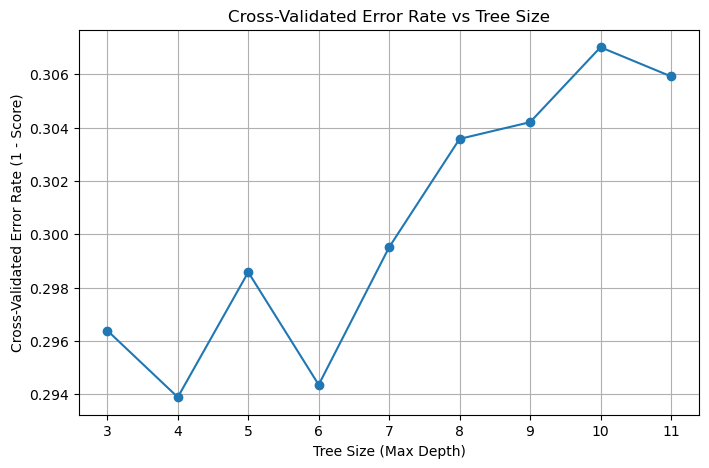

In [164]:
depths = grid_search.cv_results_['param_estimator__max_depth'].data

# Mean accuracy from cross-validation
mean_scores = grid_search.cv_results_['mean_test_score']

# Convert to error rate
error_rates = 1 - mean_scores

# Plot
plt.figure(figsize=(8, 5))
plt.plot(depths, error_rates, marker='o', linestyle='-')
plt.xlabel("Tree Size (Max Depth)")
plt.ylabel("Cross-Validated Error Rate (1 - Score)")
plt.title("Cross-Validated Error Rate vs Tree Size")
plt.xticks(depths)
plt.grid(True)
plt.show()

Picking up max depth as 4 due to low cross validation score 

In [166]:
# STEP 5: Train a Multi-Output Decision Tree
base_tree = DecisionTreeClassifier(max_depth=4, random_state=42)
multi_tree = MultiOutputClassifier(base_tree)
multi_tree.fit(X_train, y_train)

# STEP 6: Predict
y_pred = multi_tree.predict(X_test)

# STEP 7: Evaluate each target
print(" Classification Reports:")
for i, target in enumerate(targets):
    print(f"\n--- {target} ---")
    print(classification_report(y_test.iloc[:, i], y_pred[:, i]))


 Classification Reports:

--- MRJFLAG ---
              precision    recall  f1-score   support

           0       0.91      0.93      0.92      2497
           1       0.60      0.52      0.56       503

    accuracy                           0.86      3000
   macro avg       0.75      0.72      0.74      3000
weighted avg       0.85      0.86      0.86      3000


--- TOBFLAG ---
              precision    recall  f1-score   support

           0       0.90      1.00      0.95      2683
           1       0.75      0.03      0.05       317

    accuracy                           0.90      3000
   macro avg       0.82      0.51      0.50      3000
weighted avg       0.88      0.90      0.85      3000


--- ALCFLAG ---
              precision    recall  f1-score   support

           0       0.81      0.92      0.86      2246
           1       0.61      0.37      0.46       754

    accuracy                           0.78      3000
   macro avg       0.71      0.65      0.66      300

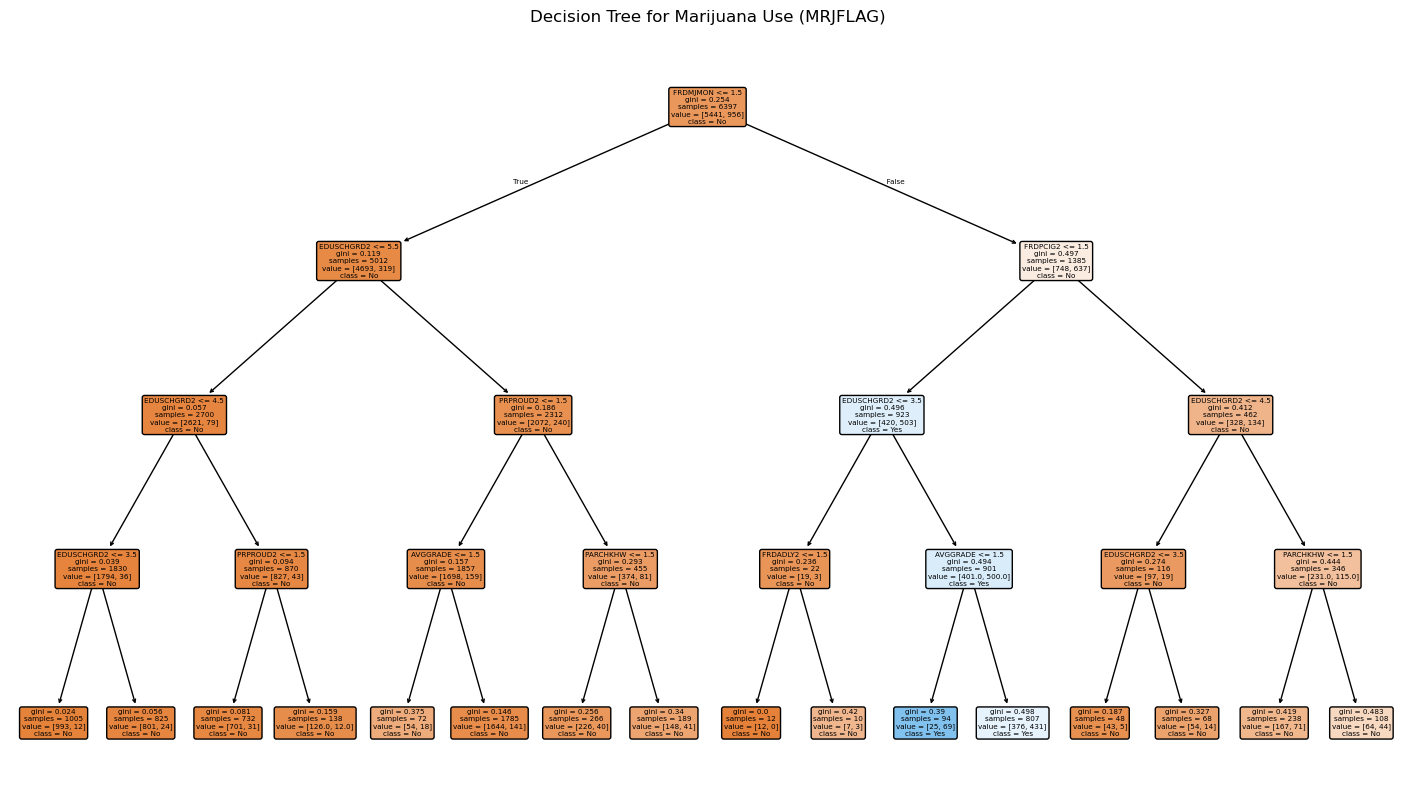

In [167]:
plt.figure(figsize=(18, 10))
plot_tree(multi_tree.estimators_[0], feature_names=predictors, class_names=["No", "Yes"], filled=True, rounded=True)
plt.title("Decision Tree for Marijuana Use (MRJFLAG)")
plt.show()

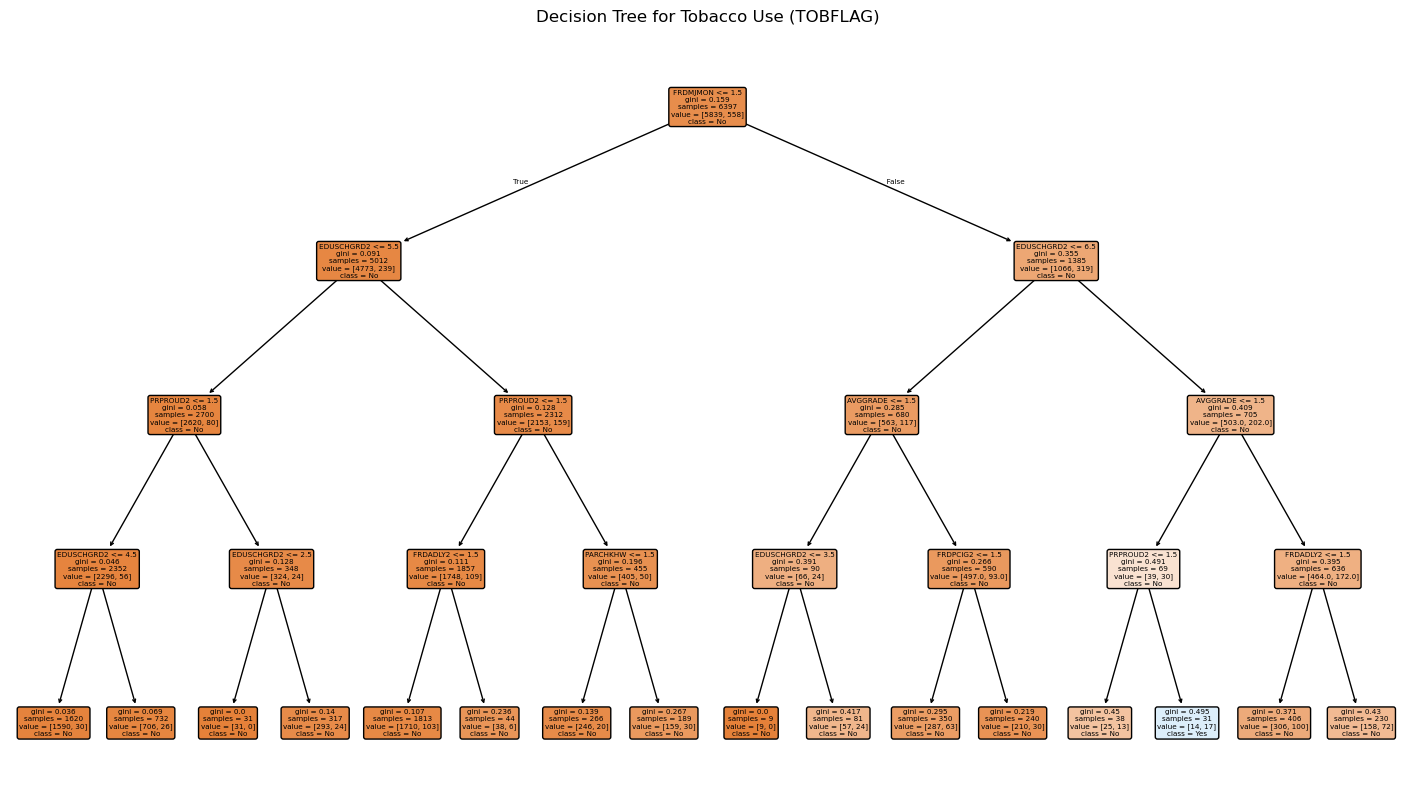

In [168]:
plt.figure(figsize=(18, 10))
plot_tree(multi_tree.estimators_[1], feature_names=predictors, class_names=["No", "Yes"], filled=True, rounded=True)
plt.title("Decision Tree for Tobacco Use (TOBFLAG)")
plt.show()

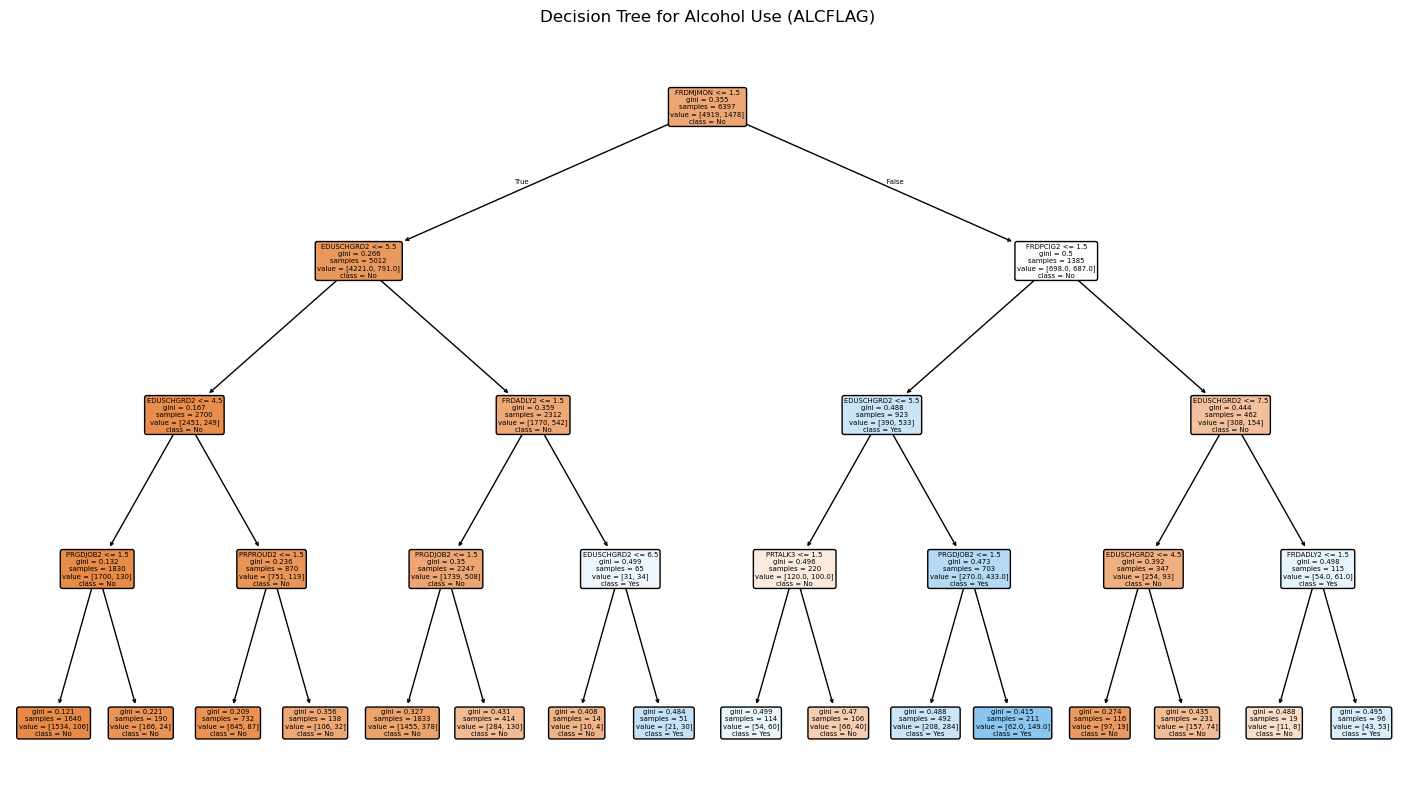

In [169]:
plt.figure(figsize=(18, 10))
plot_tree(multi_tree.estimators_[2], feature_names=predictors, class_names=["No", "Yes"], filled=True, rounded=True)
plt.title("Decision Tree for Alcohol Use (ALCFLAG)")
plt.show()

In [170]:
print("Confusion Matrices and Test Error Rates:")

for i, target in enumerate(targets):
    # Get actual and predicted values for the target
    y_true = y_test.iloc[:, i]
    y_pred_target = y_pred[:, i]
    
    # Confusion Matrix (as a DataFrame using pd.crosstab)
    confusion_df = pd.crosstab(index=y_pred_target, columns=y_true, rownames=['Predicted'], colnames=['Actual'])
    
    # Accuracy and Error Rate
    accuracy = accuracy_score(y_true, y_pred_target)
    error_rate = 1 - accuracy
    
    # Output
    print(f"target")
    print("Confusion Matrix:")
    print(confusion_df)
    print(f"Test Accuracy: {accuracy:.3f}")
    print(f"Test Error Rate: {error_rate:.3f}")

Confusion Matrices and Test Error Rates:
target
Confusion Matrix:
Actual        0    1
Predicted           
0          2324  242
1           173  261
Test Accuracy: 0.862
Test Error Rate: 0.138
target
Confusion Matrix:
Actual        0    1
Predicted           
0          2680  308
1             3    9
Test Accuracy: 0.896
Test Error Rate: 0.104
target
Confusion Matrix:
Actual        0    1
Predicted           
0          2070  473
1           176  281
Test Accuracy: 0.784
Test Error Rate: 0.216


In [171]:
balanced_rf = BalancedRandomForestClassifier(n_estimators=100, random_state=42)
balanced_rf_model = MultiOutputClassifier(balanced_rf)

# Train
balanced_rf_model.fit(X_train, y_train)

# Predict
y_pred_brf = balanced_rf_model.predict(X_test)

# Evaluate
print("Balanced Random Forest:")
for i, target in enumerate(targets):
    print(f"target")
    print(classification_report(y_test.iloc[:, i], y_pred_brf[:, i]))

Balanced Random Forest:
target
              precision    recall  f1-score   support

           0       0.93      0.81      0.86      2497
           1       0.42      0.70      0.53       503

    accuracy                           0.79      3000
   macro avg       0.68      0.76      0.70      3000
weighted avg       0.85      0.79      0.81      3000

target
              precision    recall  f1-score   support

           0       0.94      0.72      0.81      2683
           1       0.20      0.59      0.30       317

    accuracy                           0.71      3000
   macro avg       0.57      0.66      0.56      3000
weighted avg       0.86      0.71      0.76      3000

target
              precision    recall  f1-score   support

           0       0.85      0.75      0.80      2246
           1       0.45      0.61      0.52       754

    accuracy                           0.72      3000
   macro avg       0.65      0.68      0.66      3000
weighted avg       0.75      

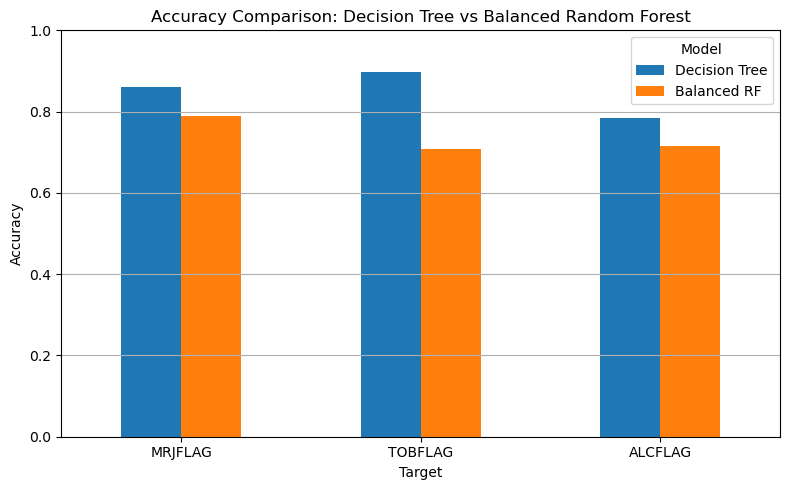

In [179]:


# Define target names
targets = ['MRJFLAG', 'TOBFLAG', 'ALCFLAG']

# Train Multi-Output Decision Tree
tree_model = MultiOutputClassifier(DecisionTreeClassifier(max_depth=4, random_state=42))
tree_model.fit(X_train, y_train)
y_pred_tree = tree_model.predict(X_test)

# Train Balanced Random Forest
brf_model = MultiOutputClassifier(BalancedRandomForestClassifier(n_estimators=100, random_state=42))
brf_model.fit(X_train, y_train)
y_pred_brf = brf_model.predict(X_test)

# Calculate accuracy for each target
acc_tree = []
acc_brf = []

for i, target in enumerate(targets):
    acc_tree.append(accuracy_score(y_test.iloc[:, i], y_pred_tree[:, i]))
    acc_brf.append(accuracy_score(y_test.iloc[:, i], y_pred_brf[:, i]))

# Plotting
acc_df = pd.DataFrame({
    'Target': targets,
    'Decision Tree': acc_tree,
    'Balanced RF': acc_brf
})

acc_df.set_index('Target').plot(kind='bar', figsize=(8, 5))
plt.title('Accuracy Comparison: Decision Tree vs Balanced Random Forest')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.grid(True, axis='y')
plt.xticks(rotation=0)
plt.legend(title='Model')
plt.tight_layout()
plt.show()



Here we can see that balanced RF accuracy is less compared to the dession tree 
But here we need keep most important points to remember 
1)Balanced RF balances the data, often sacrificing some majority-class (class 0) accuracy to improve detection of the minority class (class 1).
2)In imbalanced data, most samples are 0s. Predicting 0 always gives high accuracy, but fails to catch actual 1s.
Soo to Catch more actual drug users or Avoid false alarms (false positives) using recall/F1 score on class 1 is the best way to determine the model precision 

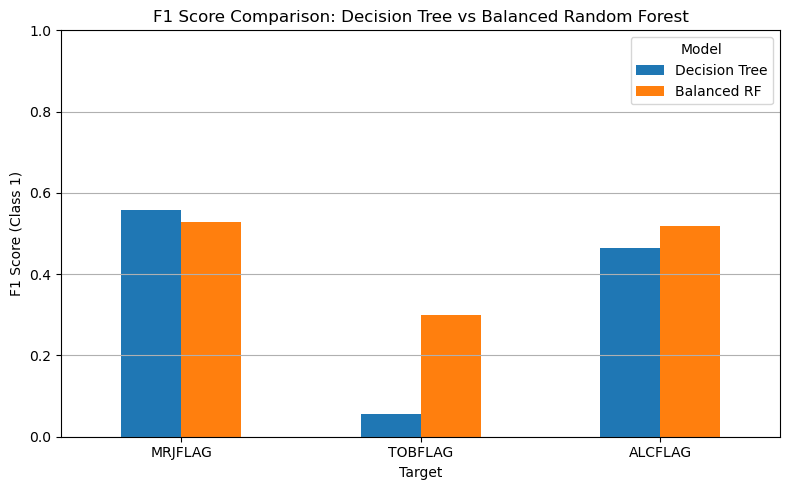

In [142]:
f1_scores_tree = []
f1_scores_brf = []

for i, target in enumerate(targets):
    f1_tree = f1_score(y_test.iloc[:, i], y_pred_tree[:, i])
    f1_brf = f1_score(y_test.iloc[:, i], y_pred_brf[:, i])
    f1_scores_tree.append(f1_tree)
    f1_scores_brf.append(f1_brf)

# === Create DataFrame for plotting ===
f1_df = pd.DataFrame({
    'Target': targets,
    'Decision Tree': f1_scores_tree,
    'Balanced RF': f1_scores_brf
})

# === Plot F1 score comparison ===
f1_df.set_index('Target').plot(kind='bar', figsize=(8, 5))
plt.title('F1 Score Comparison: Decision Tree vs Balanced Random Forest')
plt.ylabel('F1 Score (Class 1)')
plt.ylim(0, 1)
plt.grid(True, axis='y')
plt.xticks(rotation=0)
plt.legend(title='Model')
plt.tight_layout()
plt.show()